라이브러리 임포트 및 시드고정

In [2]:
## 라이브러리 임포트, 시드고정
# ⭐️ Deterministic 연산을 위한 환경 변수 강제 설정 ⭐️
# %env 명령은 셀의 가장 첫 줄에 있어야 가장 효과적입니다.
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import os
import json 
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import copy

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Deterministic 알고리즘 사용 설정 (이전 코드에서 유지됨)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # True일 경우 Deterministic을 막을 수 있음

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {device}")

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
✅ Device set to: cuda


경로 및 하이퍼파라미터 설정

In [3]:
# ★ 경로 설정 (사용자 환경에 맞게 수정) ★
DATA_ROOT = "/workspace/merge_data_binary" # 프로젝트의 루트 폴더
TRAIN_IMG_ROOT = os.path.join(DATA_ROOT, "new_data", "img_binary")
VAL_IMG_ROOT = os.path.join(DATA_ROOT, "new_data_val", "img_binary")

# 하이퍼파라미터
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS =10
LEARNING_RATE = 0.0001

In [4]:
# [Cell 2]에서 경로 설정 후, 이 셀을 실행하여 실제 파일 유무를 확인하세요.
print(f"Train Image Root: {TRAIN_IMG_ROOT}")
print(f"Val Image Root: {VAL_IMG_ROOT}")

# 폴더 존재 여부 확인
print(f"Train 폴더 존재 여부: {os.path.isdir(TRAIN_IMG_ROOT)}")
print(f"Val 폴더 존재 여부: {os.path.isdir(VAL_IMG_ROOT)}")

# 하위 감정 폴더 존재 여부 확인
print(f"Train/happy 폴더 존재 여부: {os.path.isdir(os.path.join(TRAIN_IMG_ROOT, 'happy'))}")

Train Image Root: /workspace/merge_data_binary/new_data/img_binary
Val Image Root: /workspace/merge_data_binary/new_data_val/img_binary
Train 폴더 존재 여부: True
Val 폴더 존재 여부: True
Train/happy 폴더 존재 여부: True


In [5]:
## 데이터 유효성 검증🔎
def validate_image_data(root_dir):
    print(f"🔍 데이터 검증 시작: {root_dir}")
    
    total_files = 0
    corrupt_files = 0
    
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')
    
    for root, dirs, files in os.walk(root_dir):
        image_files = [f for f in files if f.lower().endswith(valid_ext)]
        
        if len(image_files) > 0:
            print(f"  📁 Folder: {os.path.basename(root)} | Images: {len(image_files)}")
            
            for img_file in tqdm(image_files, desc=f"Checking {os.path.basename(root)}", leave=False):
                img_path = os.path.join(root, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, SyntaxError) as e:
                    print(f"    ❌ Corrupt file found: {img_path}")
                    corrupt_files += 1
                
                total_files += 1

    print("-" * 40)
    print(f"✅ 검증 완료")
    print(f"   - 총 이미지 수: {total_files}")
    print(f"   - 손상된 파일 수: {corrupt_files}")
    
    if corrupt_files > 0:
        print("⚠️ 경고: 손상된 파일이 존재합니다. 해당 파일을 제거하거나 확인해주세요.")
    else:
        print("🎉 모든 파일이 정상입니다.")

# 검증 실행
if os.path.exists(DATA_ROOT):
    validate_image_data(DATA_ROOT)
else:
    print(f"❌ 경로 오류: {DATA_ROOT} 가 존재하지 않습니다.")

🔍 데이터 검증 시작: /workspace/merge_data_binary
  📁 Folder: other | Images: 852


Checking other:   4%|▍         | 38/852 [00:00<00:04, 188.74it/s]

  📁 Folder: happy | Images: 299


  📁 Folder: other | Images: 4348


  📁 Folder: happy | Images: 5202


----------------------------------------
✅ 검증 완료
   - 총 이미지 수: 10701
   - 손상된 파일 수: 0
🎉 모든 파일이 정상입니다.


In [6]:
# [Cell 4] EmotionDataset 클래스 정의 (JSON 미사용, 폴더 스캔 기반)
class EmotionDataset(Dataset):
    """
    JSON 파일을 사용하지 않고, 폴더 구조 (happy, other) 만으로 
    이미지 경로와 레이블을 로딩하는 Dataset 클래스입니다.
    """
    def __init__(self, img_root, transform=None):
        self.img_root = img_root
        self.transform = transform
        
        # 폴더 이름과 이진 레이블 매핑
        self.emotions = ["happy", "other"] 
        self.label_map = {"happy": 1, "other": 0} 
        self.samples = [] # ⭐️ self.samples가 최종 데이터 리스트입니다.
        
        valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')

        print(f"\n[Dataset Loading: {os.path.basename(img_root)}...]")
        
        # ⭐️ 폴더 구조를 직접 스캔하여 데이터 로딩 ⭐️
        for emo in self.emotions:
            emo_dir = os.path.join(self.img_root, emo)
            
            if not os.path.isdir(emo_dir):
                print(f"🚨 FAILED: 폴더가 없습니다: {emo_dir}") 
                continue
                
            label = self.label_map[emo]
            count = 0
            
            for filename in os.listdir(emo_dir):
                if filename.lower().endswith(valid_ext):
                    img_path = os.path.join(emo_dir, filename)
                    self.samples.append((img_path, label))
                    count += 1
            
            # ⭐️ 각 클래스별 로딩 개수 확인
            print(f"🔍 CHECK: {emo_dir} 에서 {count}개 찾음") 
            
        random.shuffle(self.samples)
        # ⭐️ 로딩이 성공했다면 이 값은 0보다 커야 합니다.
        print(f"  >> Total samples loaded: {len(self.samples)}개")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # 에러 발생 시 0번 인덱스 이미지로 대체 (깨진 파일 검증을 통과했다면 발생 가능성은 낮음)
            print(f"Error loading image {img_path}: {e}. Skipping to index 0.")
            return self.__getitem__(0)

        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [7]:
# ResNet 기본 입력 크기 224x224 기준
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # 정규화 유지 (모델 학습 안정성을 위한 필수 전처리)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# 데이터셋 생성 (⭐️ TRAIN_IMG_ROOT, VAL_IMG_ROOT 변수 사용 및 split 파라미터 제거)
train_dataset = EmotionDataset(TRAIN_IMG_ROOT, transform=train_transform)
val_dataset   = EmotionDataset(VAL_IMG_ROOT, transform=val_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("\n✅ DataLoaders are ready.")


[Dataset Loading: img_binary...]
🔍 CHECK: /workspace/merge_data_binary/new_data/img_binary/happy 에서 5202개 찾음
🔍 CHECK: /workspace/merge_data_binary/new_data/img_binary/other 에서 4348개 찾음
  >> Total samples loaded: 9550개

[Dataset Loading: img_binary...]
🔍 CHECK: /workspace/merge_data_binary/new_data_val/img_binary/happy 에서 299개 찾음
🔍 CHECK: /workspace/merge_data_binary/new_data_val/img_binary/other 에서 852개 찾음
  >> Total samples loaded: 1151개

✅ DataLoaders are ready.


In [8]:
## CBAM 모듈 및 ResNetCBAM 모델 정의 (⭐️ CBAM 추가됨)CBAM 모듈 및 ResNetCBAM 모델 정의 (⭐️ CBAM 추가됨)
## CBAM 모듈과, ResNet에 CBAM을 통합한 ResNetCBAM 모델을 정의합니다.

print("🛠️ CBAM 모듈 및 ResNetCBAM 모델 설정 중...")

# ⭐️ 채널 어텐션 모듈 (Channel Attention Module) 정의
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.ReLU(),
                                nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

# ⭐️ 공간 어텐션 모듈 (Spatial Attention Module) 정의
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_out = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_out)
        return self.sigmoid(x_out)

# ⭐️ CBAM (Channel and Spatial Attention Module) 정의
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# ⭐️ ResNet18 백본에 CBAM을 통합한 모델 정의
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        
        # 1. 사전학습된 ResNet18 로드
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # ResNet의 초기 Conv1, bn1, relu, maxpool을 그대로 사용
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # ResNet의 각 Stage (layer1, layer2, layer3, layer4)를 가져옴
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # ⭐️ 각 Residual Block 이후 또는 Layer 이후에 CBAM 모듈 삽입 ⭐️
        # ResNet18의 각 레이어의 출력 채널에 맞춰 CBAM을 초기화합니다.
        #self.cbam1 = CBAM(64)  # layer1의 출력 채널 (ResNet18)
        self.cbam2 = CBAM(128) # layer2의 출력 채널
        self.cbam3 = CBAM(256) # layer3의 출력 채널
        #self.cbam4 = CBAM(512) # layer4의 출력 채널
        ## CBAM 모듈은 stage 2,3에만 적용
        
        self.avgpool = resnet.avgpool
        
        # 최종 분류기를 2클래스로 교체
        num_features = resnet.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.cbam1(x) # ⭐️ CBAM 삽입 지점
        x = self.layer2(x)
        x = self.cbam2(x) # ⭐️ CBAM 삽입 지점
        x = self.layer3(x)
        x = self.cbam3(x) # ⭐️ CBAM 삽입 지점
        x = self.layer4(x)
        x = self.cbam4(x) # ⭐️ CBAM 삽입 지점
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)# ⭐️ ResNet18 백본에 CBAM을 Stage 2와 3에만 통합한 모델 정의
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        
        # 1. 사전학습된 ResNet18 로드
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # ResNet의 초기 Conv1, bn1, relu, maxpool을 그대로 사용
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # ResNet의 각 Stage (layer1, layer2, layer3, layer4)를 가져옴
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # ⭐️ Stage 2와 Stage 3의 출력 채널에 맞춰 CBAM 초기화
        self.cbam2 = CBAM(128) # layer2의 출력 채널
        self.cbam3 = CBAM(256) # layer3의 출력 채널
        
        # self.cbam1과 self.cbam4는 정의하지 않음
        
        self.avgpool = resnet.avgpool
        
        # 최종 분류기를 2클래스로 교체
        num_features = resnet.fc.in_features
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        # x = self.cbam1(x) # ⭐️ Stage 1 CBAM 제거
        
        x = self.layer2(x)
        x = self.cbam2(x) # ⭐️ Stage 2 CBAM 유지
        
        x = self.layer3(x)
        x = self.cbam3(x) # ⭐️ Stage 3 CBAM 유지
        
        x = self.layer4(x)
        # x = self.cbam4(x) # ⭐️ Stage 4 CBAM 제거
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 모델, 손실함수, 최적화함수 초기화
model = ResNetCBAM(num_classes=2).to(device) # ResNetCBAM 모델 사용
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("✅ ResNetCBAM Model (CBAM @ Stage 2, 3) is ready!")

🛠️ CBAM 모듈 및 ResNetCBAM 모델 설정 중...


✅ ResNetCBAM Model (CBAM @ Stage 2, 3) is ready!


In [11]:
## 학습 함수 정의 ## epochs 설정
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
        
        # ⭐️ 학습 후 GPU 캐시 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.inference_mode():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)
        
        # ⭐️ 검증 후 GPU 캐시 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        val_loss /= val_total
        val_acc = val_corrects.double() / val_total
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Best Model 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "Res_CBAM_v3_4class.pth") # ⭐️ 파일명 변경
            print(f"⭐ Best model saved! (Acc: {best_val_acc:.4f})")

    print(f"\nTraining Complete. Best Val Acc: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [12]:
## 학습 실행
# 학습 시작
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)


Epoch 1/10
------------------------------


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Train Loss: 0.1762 Acc: 0.9360


Val   Loss: 0.1721 Acc: 0.9374
⭐ Best model saved! (Acc: 0.9374)

Epoch 2/10
------------------------------


Train Loss: 0.0908 Acc: 0.9702


Val   Loss: 0.3068 Acc: 0.8879

Epoch 3/10
------------------------------


Train Loss: 0.0612 Acc: 0.9791


Val   Loss: 0.1707 Acc: 0.9409
⭐ Best model saved! (Acc: 0.9409)

Epoch 4/10
------------------------------


Train Loss: 0.0463 Acc: 0.9840


Val   Loss: 0.1650 Acc: 0.9348

Epoch 5/10
------------------------------


Train Loss: 0.0306 Acc: 0.9894


Val   Loss: 0.2246 Acc: 0.9374

Epoch 6/10
------------------------------


Train Loss: 0.0250 Acc: 0.9932


Val   Loss: 0.1952 Acc: 0.9470
⭐ Best model saved! (Acc: 0.9470)

Epoch 7/10
------------------------------


Train Loss: 0.0149 Acc: 0.9949


Val   Loss: 0.3296 Acc: 0.9322

Epoch 8/10
------------------------------


Train Loss: 0.0256 Acc: 0.9917


Val   Loss: 0.2491 Acc: 0.9427

Epoch 9/10
------------------------------


Train Loss: 0.0194 Acc: 0.9930


Val   Loss: 0.2791 Acc: 0.9340

Epoch 10/10
------------------------------


Train Loss: 0.0150 Acc: 0.9958


Val   Loss: 0.3543 Acc: 0.9305

Training Complete. Best Val Acc: 0.9470


In [13]:
## 성능 평가
print("\n📊 최종 성능 평가 중...")

trained_model.eval()
all_labels = []
all_preds = []

with torch.inference_mode():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Metrics 계산
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, pos_label=1)
rec  = recall_score(all_labels, all_preds, pos_label=1)
f1   = f1_score(all_labels, all_preds, pos_label=1)
cm   = confusion_matrix(all_labels, all_preds)

print("\n=== Val Metrics (binary: 1=HAPPY, 0=OTHERS) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix (rows: true, cols: pred)")
print(cm)

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=["OTHERS", "HAPPY"]))


📊 최종 성능 평가 중...


Evaluating: 100%|██████████| 36/36 [00:26<00:00,  1.38it/s]


=== Val Metrics (binary: 1=HAPPY, 0=OTHERS) ===
Accuracy : 0.9470
Precision: 0.8606
Recall   : 0.9498
F1-score : 0.9030

Confusion Matrix (rows: true, cols: pred)
[[806  46]
 [ 15 284]]

Classification report:
              precision    recall  f1-score   support

      OTHERS       0.98      0.95      0.96       852
       HAPPY       0.86      0.95      0.90       299

    accuracy                           0.95      1151
   macro avg       0.92      0.95      0.93      1151
weighted avg       0.95      0.95      0.95      1151




📊 최종 성능 평가 중...


Evaluating: 100%|██████████| 36/36 [00:26<00:00,  1.36it/s]


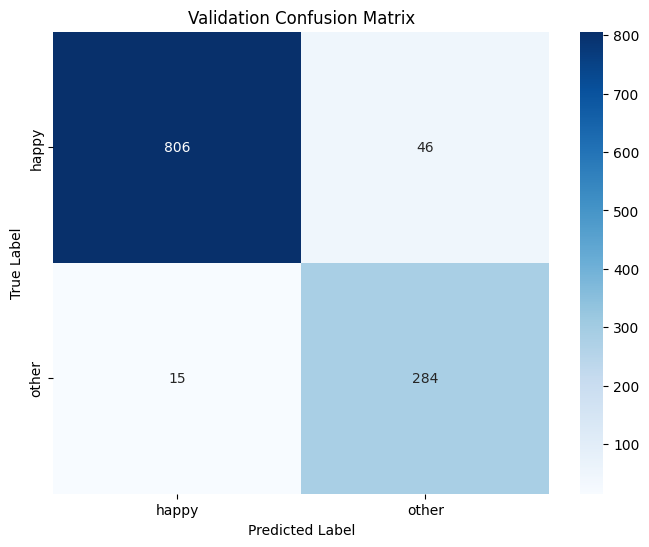

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
# 이 네 가지 라이브러리가 필요합니다.

def plot_confusion_matrix(all_labels, all_preds, target_emotions, title="Confusion Matrix"):
    """
    컨퓨전 매트릭스를 계산하고 히트맵으로 시각화합니다.
    
    Args:
        all_labels (np.array): 실제 레이블 (정답)
        all_preds (np.array): 모델의 예측 레이블
        target_emotions (list): 레이블 이름 리스트 (예: ['anger', 'happy', ...])
        title (str): 그래프 제목
    """
    
    # 1. 컨퓨전 매트릭스 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 2. 시각화 설정
    plt.figure(figsize=(8, 6))
    
    # 히트맵 생성 (fmt='d'는 정수형 포맷을 의미)
    sns.heatmap(
        cm, 
        annot=True,          # 셀 안에 값 표시
        fmt='d',             # 정수형 포맷
        cmap='Blues',        # 색상 맵 설정
        xticklabels=target_emotions, # X축 레이블 (예측)
        yticklabels=target_emotions  # Y축 레이블 (실제)
    )
    
    # 3. 레이블 및 제목 설정
    plt.title(title)
    plt.ylabel('True Label') # 실제 레이블 (정답)
    plt.xlabel('Predicted Label') # 예측 레이블
    plt.show()



TARGET_EMOTIONS = ["happy","other"] 

# 📊 최종 성능 평가 수행 부분
trained_model = model # 학습된 모델을 사용하거나 불러온 모델을 사용
print("\n📊 최종 성능 평가 중...")

trained_model.eval()
all_labels = []
all_preds = []

if len(val_loader.dataset) > 0:
    with torch.inference_mode():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1) # 예측값 (클래스 인덱스)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # ⭐️ 시각화 함수 호출!
    plot_confusion_matrix(all_labels, all_preds, TARGET_EMOTIONS, "Validation Confusion Matrix")
    
    # ... (classification_report 출력 로직) ...
else:
    print("⚠️ 경고: 유효성 검증 데이터셋에 로드된 샘플이 없어 평가를 건너뜁니다.")